## 데이터 불러오기

In [54]:
import pandas as pd
df=pd.read_csv('data/V7XJ9_10min.csv')

## RPM70 이상 데이터만 스크리닝해야됨

(60.0, 80.0)

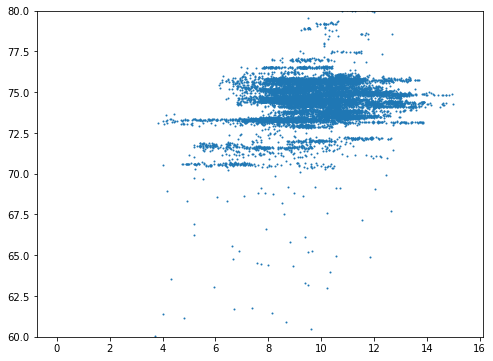

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(df['SPEED_VG'],df['ME1_RPM'],s=1)
plt.ylim(60,80)

(0.0, 110.0)

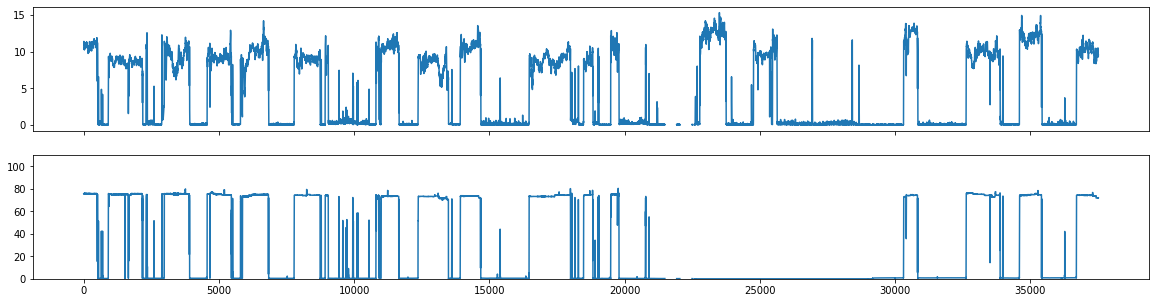

In [30]:
fig,axes = plt.subplots(2,1,figsize=(20,5),sharex=True)
axes[0].plot(df['SPEED_VG'])
axes[1].plot(df['ME1_RPM'])
axes[1].set_ylim(0,110)

## 20000~30000사이에 RPM이 존재하지 않으므로 제거

In [31]:
# Removing Weired Region
df2=pd.concat([df.iloc[:20000],df.iloc[30000:]])
# Extracting DF by RPM value
df2=df2[df2['ME1_RPM']>70]
# Reindexing
df2=df2.reset_index()

(70.0, 81.0446083335)

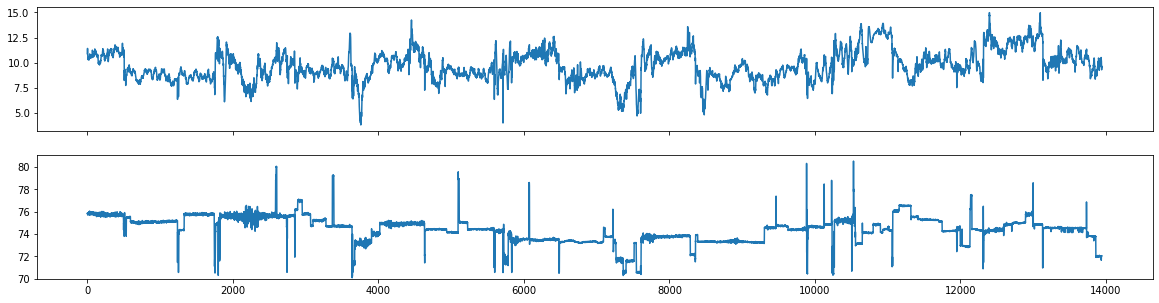

In [32]:
fig,axes = plt.subplots(2,1,figsize=(20,5),sharex=True)
axes[0].plot(df2['SPEED_VG'])
axes[1].plot(df2['ME1_RPM'])
axes[1].set_ylim(70)


## 필요없는 변수 선정

In [33]:
exclude=['ME1_FO_FLOW_HOUR_INLET','ME1_FO_DENSITY_INLET','ME1_FO_TEMP_INLET',
         'ME1_FO_TOTALIZER_INLET','ME1_RPM_ECC','ME1_SCAV_AIR_PRESS_ECC']
columns=[i for i in df.columns if i.startswith('ME1') and i not in exclude]
raw=df2[columns]

## Isolation Forest 학습

In [55]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=42)
clf.fit(raw)

IsolationForest(random_state=42)

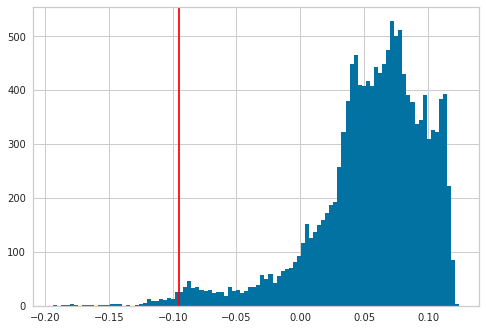

In [61]:
import numpy as np
p=np.percentile(clf.decision_function(raw),1)
plt.hist(clf.decision_function(raw),100)
plt.axvline(p, color='red')

## Shapley Value 검출

In [62]:
import shap
explainer=shap.TreeExplainer(clf)
shap_values = explainer.shap_values(raw)

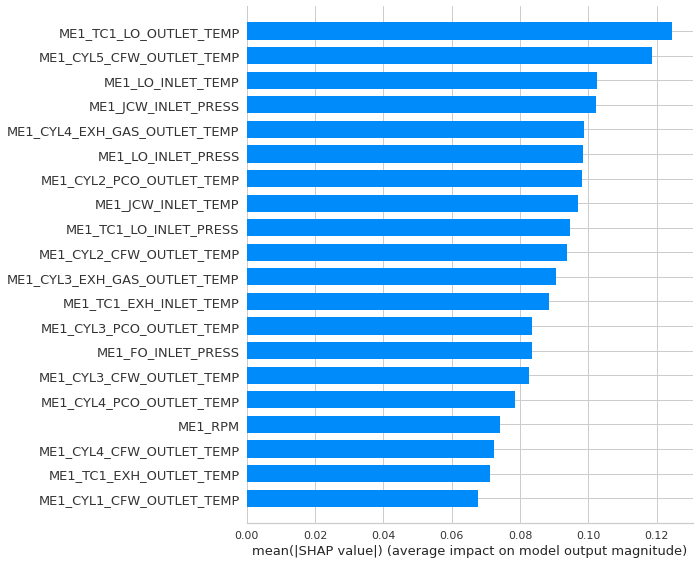

In [63]:
shap.summary_plot(shap_values, raw, plot_type="bar")

## Extracting Outliers

In [70]:
score=clf.decision_function(raw)
outlier=np.argsort(score)
size=len(score)
percent=0.01
outlierIdx=outlier[:int(size*percent)]

## Clustering Analysis

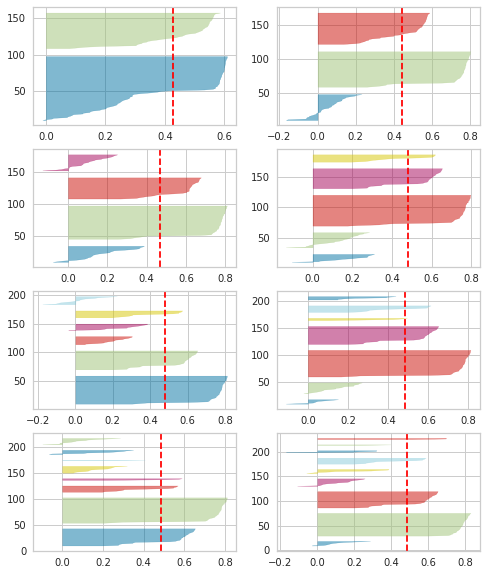

In [79]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

X=shap_values[outlierIdx]
cluster={}
result=[]
for i in range(2,10):
    cluster[i]=KMeans(n_clusters=i)
    pred=cluster[i].fit_predict(X)
 
fig, ax = plt.subplots(4, 2, figsize=(8,10))
for i in range(2,10):
    '''
    Create KMeans instance for different number of clusters
    '''
    # km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(cluster[i], colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)  

In [80]:
y=cluster[5].predict(X)

In [87]:
X=pd.DataFrame(shap_values).iloc[outlierIdx]
X.columns=raw.columns

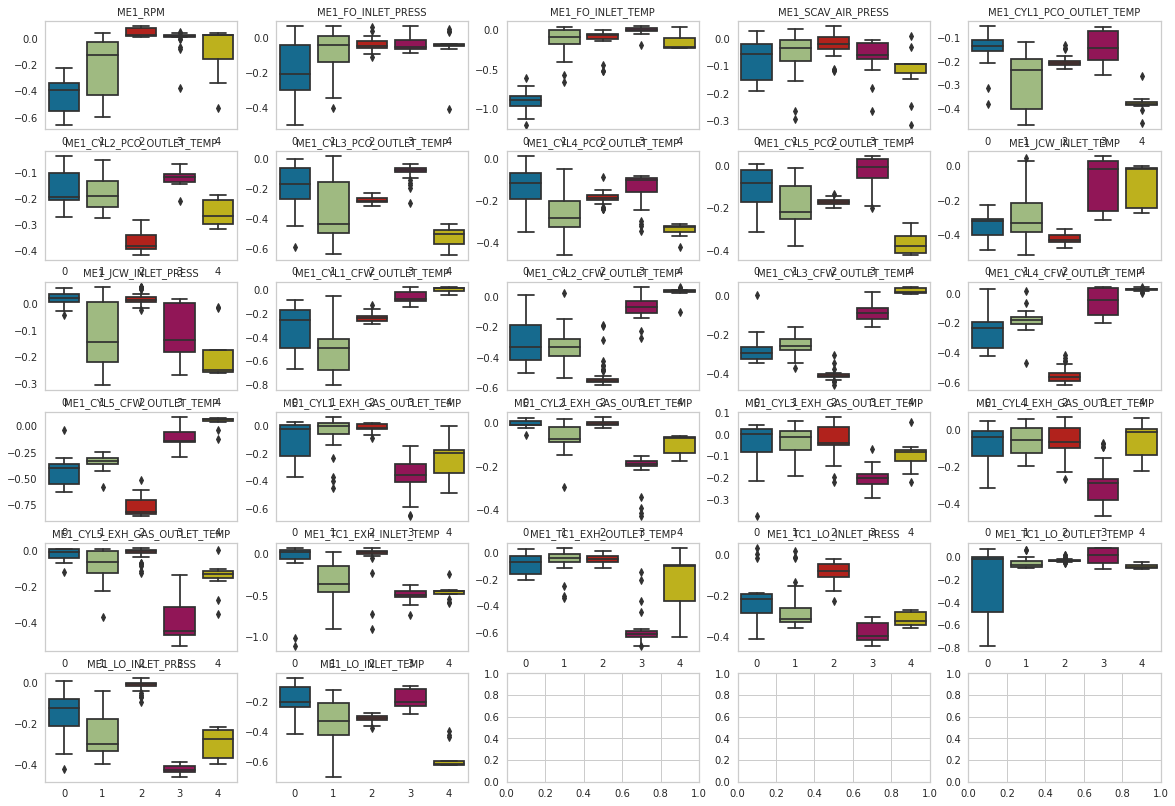

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axes = plt.subplots(6, 5, figsize=(20, 14))
count=0
for i in range(len(columns)):
    ax=f.axes[i]
    c=X.columns[i]
    sns.boxplot(x=y,y=c,data=X,ax=ax)
    ax.set_title(c,  fontsize=10)
    ax.title.set_position((0.5,0.1))
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.grid(False)


    count = count + 1

## Another Clustering (DBSCAN)

In [66]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
idx=outlier[0]
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[idx,:], raw.iloc[idx,:])


In [ ]:
print(explainer.expected_value)
print(shap_values[idx,:])
print(raw.iloc[idx,:])

[12.11519021]
[ 0.09838775  0.10508325  0.06099474  0.00943111  0.04415833  0.11187065
  0.01067569 -0.01556368 -0.01759465  0.0624719   0.06159028  0.06469315
  0.07483513  0.06426438  0.08389997  0.06406332 -0.01348563  0.05560521
 -0.0227723  -0.10316566 -0.10099571  0.10107946  0.05747508 -0.10909188
  0.05180418 -0.10252449  0.10958253]
ME1_RPM                          74.913000
ME1_FO_INLET_PRESS                7.412067
ME1_FO_INLET_TEMP               137.153333
ME1_SCAV_AIR_PRESS                1.078000
ME1_CYL1_PCO_OUTLET_TEMP         49.478333
ME1_CYL2_PCO_OUTLET_TEMP         50.078333
ME1_CYL3_PCO_OUTLET_TEMP         49.800000
ME1_CYL4_PCO_OUTLET_TEMP         49.700000
ME1_CYL5_PCO_OUTLET_TEMP         49.498333
ME1_JCW_INLET_TEMP               70.453333
ME1_JCW_INLET_PRESS               3.583533
ME1_CYL1_CFW_OUTLET_TEMP         77.160000
ME1_CYL2_CFW_OUTLET_TEMP         79.765000
ME1_CYL3_CFW_OUTLET_TEMP         78.085000
ME1_CYL4_CFW_OUTLET_TEMP         77.581667
ME1_CYL5_CF

In [93]:
!curl https://raw.githubusercontent.com/creationix/nvm/v0.30.2/install.sh | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7750  100  7750    0     0  17653      0 --:--:-- --:--:-- --:--:-- 17653
=> Downloading nvm from git to '/root/.nvm'
=> Cloning into '/root/.nvm'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 7968 (delta 0), reused 2 (delta 0), pack-reused 7960
Receiving objects: 100% (7968/7968), 2.84 MiB | 2.17 MiB/s, done.
Resolving deltas: 100% (5027/5027), done.
* (HEAD detached at v0.30.2)
  master

=> Appending source string to /root/.bashrc
=> Close and reopen your terminal to start using nvm


In [94]:
!source ~/.bash_profile

/bin/sh: 1: source: not found


In [92]:
!pip install --upgrade jupyterlab jupyterlab-git
!jupyter lab build

     |████████████████████████████████| 7.9 MB 1.4 MB/s eta 0:00:01
Requirement already up-to-date: jupyterlab-git in /usr/local/lib/python3.6/dist-packages (0.23.1)
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 2.2.6
    Uninstalling jupyterlab-2.2.6:
      Successfully uninstalled jupyterlab-2.2.6
[LabBuildApp] JupyterLab 2.2.9
[LabBuildApp] Building in /usr/local/share/jupyter/lab
Build failed.
Troubleshooting: If the build failed due to an out-of-memory error, you
may be able to fix it by disabling the `dev_build` and/or `minimize` options.

If you are building via the `jupyter lab build` command, you can disable
these options like so:

jupyter lab build --dev-build=False --minimize=False

You can also disable these options for all JupyterLab builds by adding these
lines to a Jupyter config file named `jupyter_config.py`:

c.LabBuildApp.minimize = False
c.LabBuildApp.dev_build = False

If you don't already have a `jupyter_config.py` file, you can cr